# A2Perf: Analyzing generated websites for Web Navigation

## Importing libraries

In [2]:
import json
import multiprocessing as mp
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

from a2perf.domains.web_navigation.environment_generation import website_util

## Loading the websites

In [3]:
websites_path = os.path.join('../../../',
                             'a2perf/domains/web_navigation/environment_generation',
                             'data', 'designs.pkl')
websites_path

'../../../a2perf/domains/web_navigation/environment_generation/data/designs.pkl'

In [4]:
designs = pickle.load(open(websites_path, 'rb'))
designs

[{'number_of_pages': 3,
  'action': [37, 19, 9, 11, 34, 16],
  'action_page': [0, 0, 0, 1, 2, 2]},
 {'number_of_pages': 3,
  'action': [37, 19, 9, 11, 34, 16],
  'action_page': [0, 0, 0, 1, 2, 2]},
 {'number_of_pages': 3,
  'action': [37, 19, 9, 11, 34, 16],
  'action_page': [0, 0, 0, 1, 2, 2]},
 {'number_of_pages': 3,
  'action': [37, 19, 9, 11, 34, 16],
  'action_page': [0, 0, 0, 1, 2, 2]},
 {'number_of_pages': 3,
  'action': [37, 19, 9, 11, 34, 16],
  'action_page': [0, 0, 0, 1, 2, 2]},
 {'number_of_pages': 3,
  'action': [37, 19, 9, 11, 34, 16],
  'action_page': [0, 0, 0, 1, 2, 2]},
 {'number_of_pages': 3,
  'action': [37, 19, 9, 11, 34, 16],
  'action_page': [0, 0, 0, 1, 2, 2]},
 {'number_of_pages': 3,
  'action': [37, 19, 9, 11, 34, 16],
  'action_page': [0, 0, 0, 1, 2, 2]},
 {'number_of_pages': 3,
  'action': [37, 19, 9, 11, 34, 16],
  'action_page': [0, 0, 0, 1, 2, 2]},
 {'number_of_pages': 3,
  'action': [37, 19, 9, 11, 34, 16],
  'action_page': [0, 0, 0, 1, 2, 2]},
 {'number_

In [5]:
with mp.Pool(mp.cpu_count()) as pool:
  # A single website would be instantiation as website_util.Website(designs[0])
  # We need to do this for all websites in designs
  websites = pool.map(website_util.Website, designs)


In [5]:
difficulties = [website.difficulty for website in websites]
difficulties = np.array(difficulties)

## Visualizing statistics about the websites

In [6]:
# Seed for reproducibility
np.random.seed(0)


In [7]:
difficulties.min()

-1.9999999778450582e-08

(array([1.3923e+05, 3.8157e+05, 3.2820e+05, 1.0060e+05, 3.5500e+04,
        1.1500e+04, 2.2000e+03, 6.0000e+02, 4.0000e+02, 2.0000e+02]),
 array([-1.99999998e-08,  1.10672834e+01,  2.21345669e+01,  3.32018504e+01,
         4.42691339e+01,  5.53364173e+01,  6.64037008e+01,  7.74709843e+01,
         8.85382677e+01,  9.96055512e+01,  1.10672835e+02]),
 <BarContainer object of 10 artists>)

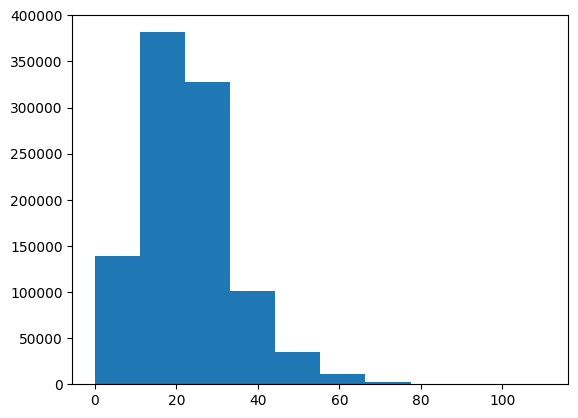

In [8]:
# Plot histogram of website difficulties
plt.hist(difficulties)

In [9]:
# Describe the distribution of difficulties
mean_difficulty = np.mean(difficulties)
std_difficulty = np.std(difficulties)
min_difficulty = np.min(difficulties)
max_difficulty = np.max(difficulties)

mean_difficulty, std_difficulty, min_difficulty, max_difficulty

(22.812345299572943,
 11.67234837058761,
 -1.9999999778450582e-08,
 110.67283467114214)

980000

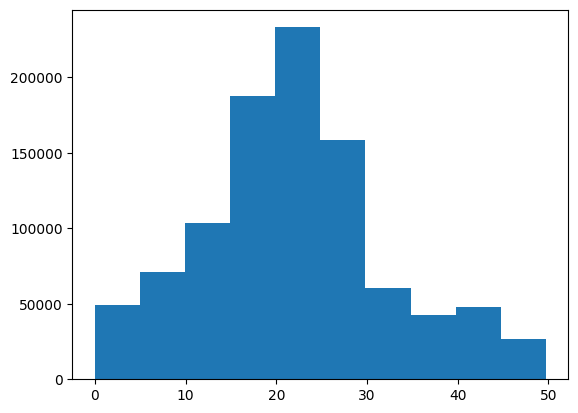

In [10]:
# Plot histogram again but remove outliers that are too difficult
MAX_DIFFICULTY = 50
subset_to_use = [website for website in websites if website.difficulty <
                 MAX_DIFFICULTY]
plt.hist([website.difficulty for website in subset_to_use])
len(subset_to_use)

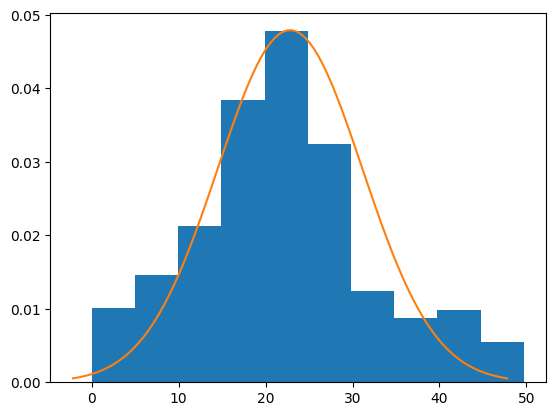

In [11]:
# Can we plot a normal distribution on top of this?

# Use the same mean as the overall distribution
subset_to_use_difficulties = [website.difficulty for website in subset_to_use]
mu = mean_difficulty
std = np.std(
    subset_to_use_difficulties) * 0.81  # 0fudge factor to make the std of the normal distribution match the std of the subset of websites
plt.hist(subset_to_use_difficulties, density=True)
# use built in normal distribution function

x = np.linspace(mu - 3 * std, mu + 3 * std, 100)
plt.plot(x, norm.pdf(x, mu, std))

## Approach 1: Three difficulty levels
These difficulty levels are based on randomly sampling from three partitions.
1. Easy: Bottom 16% of websites
2. Medium: Middle 68% of websites
3. Hard: Top 16% of websites

In [12]:
easy_bounds = [0, 0.16]
medium_bounds = [0.16, 0.84]
hard_bounds = [0.84, 1.0]

# get the inverse CDF values at the bounds for each difficulty level
easy_bounds = norm.ppf(easy_bounds, mu, std)
medium_bounds = norm.ppf(medium_bounds, mu, std)
hard_bounds = norm.ppf(hard_bounds, mu, std)
easy_bounds, medium_bounds, hard_bounds

(array([       -inf, 14.53740006]),
 array([14.53740006, 31.08729054]),
 array([31.08729054,         inf]))

In [13]:
easy_websites = [website for website in websites
                 if website.difficulty < easy_bounds[1]]
medium_websites = [website for website in websites
                   if website.difficulty >= medium_bounds[
                     0] and website.difficulty <
                   medium_bounds[1]]
hard_websites = [website for website in websites
                 if
                 website.difficulty >= hard_bounds[0] and website.difficulty <
                 MAX_DIFFICULTY]

Text(0, 0.5, 'Number of websites')

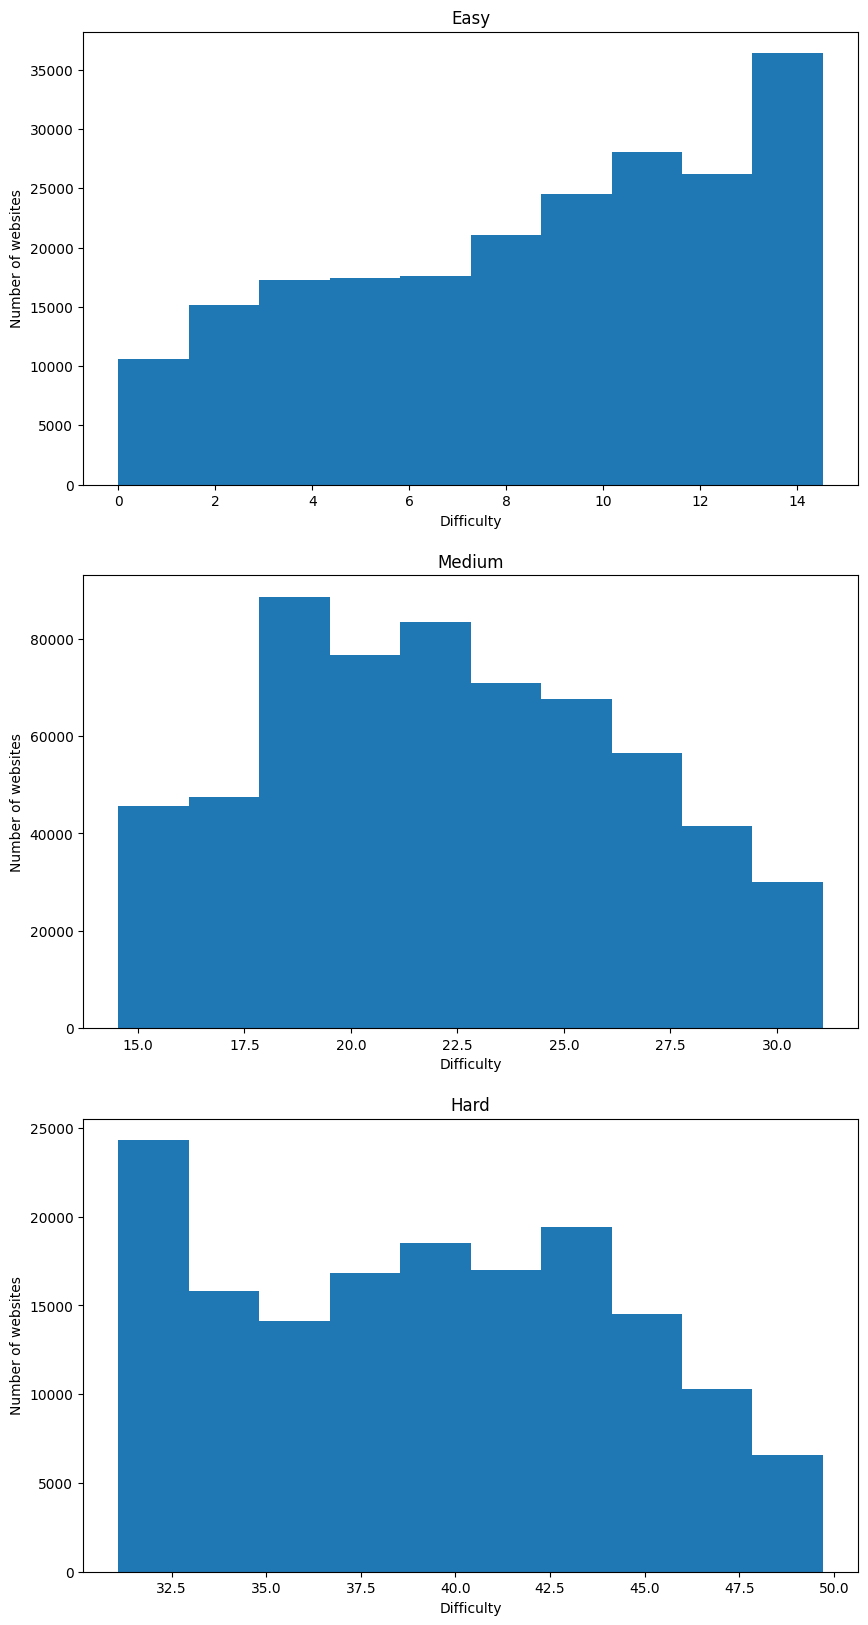

In [14]:
# Plot distributions for each on separate subplots to see if they look reasonable
fig, axs = plt.subplots(3, 1, figsize=(10, 20))
axs[0].hist([website.difficulty for website in easy_websites])
axs[1].hist([website.difficulty for website in medium_websites])
axs[2].hist([website.difficulty for website in hard_websites])
# Please label and color them properly

axs[0].set_title('Easy')
axs[1].set_title('Medium')
axs[2].set_title('Hard')

axs[0].set_xlabel('Difficulty')
axs[1].set_xlabel('Difficulty')
axs[2].set_xlabel('Difficulty')

axs[0].set_ylabel('Number of websites')
axs[1].set_ylabel('Number of websites')
axs[2].set_ylabel('Number of websites')


In [15]:
easy_designs = [website.convert_to_design() for website in easy_websites]
medium_designs = [website.convert_to_design() for website in medium_websites]
hard_designs = [website.convert_to_design() for website in hard_websites]

In [16]:
# Save all of the designs from subsets_to_use in a single json file
difficulty_mapping = {
    1: easy_designs,
    2: medium_designs,
    3: hard_designs
}

base_dir = os.path.join('../../../',
                        'a2perf/domains/web_navigation/environment_generation',
                        'data', 'difficulty_levels')
os.makedirs(base_dir, exist_ok=True)

for difficulty_level, designs in difficulty_mapping.items():
  difficulty_level_path = os.path.join(base_dir, f'{difficulty_level:02d}.json')
  json.dump(designs, open(difficulty_level_path, 'w'))


### Visualizing the actual websites

In [17]:
import gymnasium as gym
from a2perf.domains import web_navigation

In [18]:
env = gym.make('WebNavigation-v0', difficulty=1, num_websites=10,
               render_mode='image')
env.reset()

/home/ike2030/miniconda3/envs/a2perf/lib/python3.8/site-packages/gymnasium/envs/registration.py:787: UserWarning: WARN: The environment is being initialised with render_mode='image' that is not in the possible render_modes ([]).
  logger.warn(


base_url:  file:///home/ike2030/workspace/a2perf/rl-perf/a2perf/domains/web_navigation/gwob/
base_url:  file:///home/ike2030/workspace/a2perf/rl-perf/a2perf/domains/web_navigation/gwob/
url:  file:///home/ike2030/workspace/a2perf/rl-perf/a2perf/domains/web_navigation/gwob/gminiwob/generic_website.html


({'profile_key': array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [6, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [7, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 

In [47]:
# Write a simple loop to capture some screenshots of websites
NUM_SCREENSHOTS = 100
screenshots = []
env.reset()
for i in range(NUM_SCREENSHOTS):
  screenshots.append(env.render())
  action = env.action_space.sample()
  obs, rew, terminated, truncated, info = env.step(action)
  if terminated or truncated:
    env.reset()

env.close()
del env

screenshots

KeyboardInterrupt: 

## Approach 2: Website Difficulties as probabilities
Recall that the difficulty of each webpage is the negative log probability of a random agent successfully filling out the website. For example, if the agent has a 1% chance of filling out the website, then the difficulty is $-\log(0.01) = 4.6$.

 Let's try making it such that a **random agent** has an X% chance of filling out the website for each difficulty level

Easy - 50% chance of filling out the website
Medium - 25% chance of filling out the website
Hard - 10% chance of filling out the website

In [6]:
easy_bounds = -np.log([1.0, 0.5])
medium_bounds = -np.log([.5, 0.25])
hard_bounds = -np.log([0.25, 1e-9, ])

easy_bounds, medium_bounds, hard_bounds

(array([-0.        ,  0.69314718]),
 array([0.69314718, 1.38629436]),
 array([ 1.38629436, 20.72326584]))

In [49]:
easy_websites = [website for website in websites
                 if website.difficulty < easy_bounds[1]]
medium_websites = [website for website in websites
                   if website.difficulty >= medium_bounds[
                     0] and website.difficulty <
                   medium_bounds[1]]
hard_websites = [website for website in websites
                 if
                 website.difficulty >= hard_bounds[0] and website.difficulty <
                 hard_bounds[1]]

In [52]:
len(easy_websites), len(medium_websites), len(hard_websites)

(5480, 4600, 439920)

Text(0, 0.5, 'Number of websites')

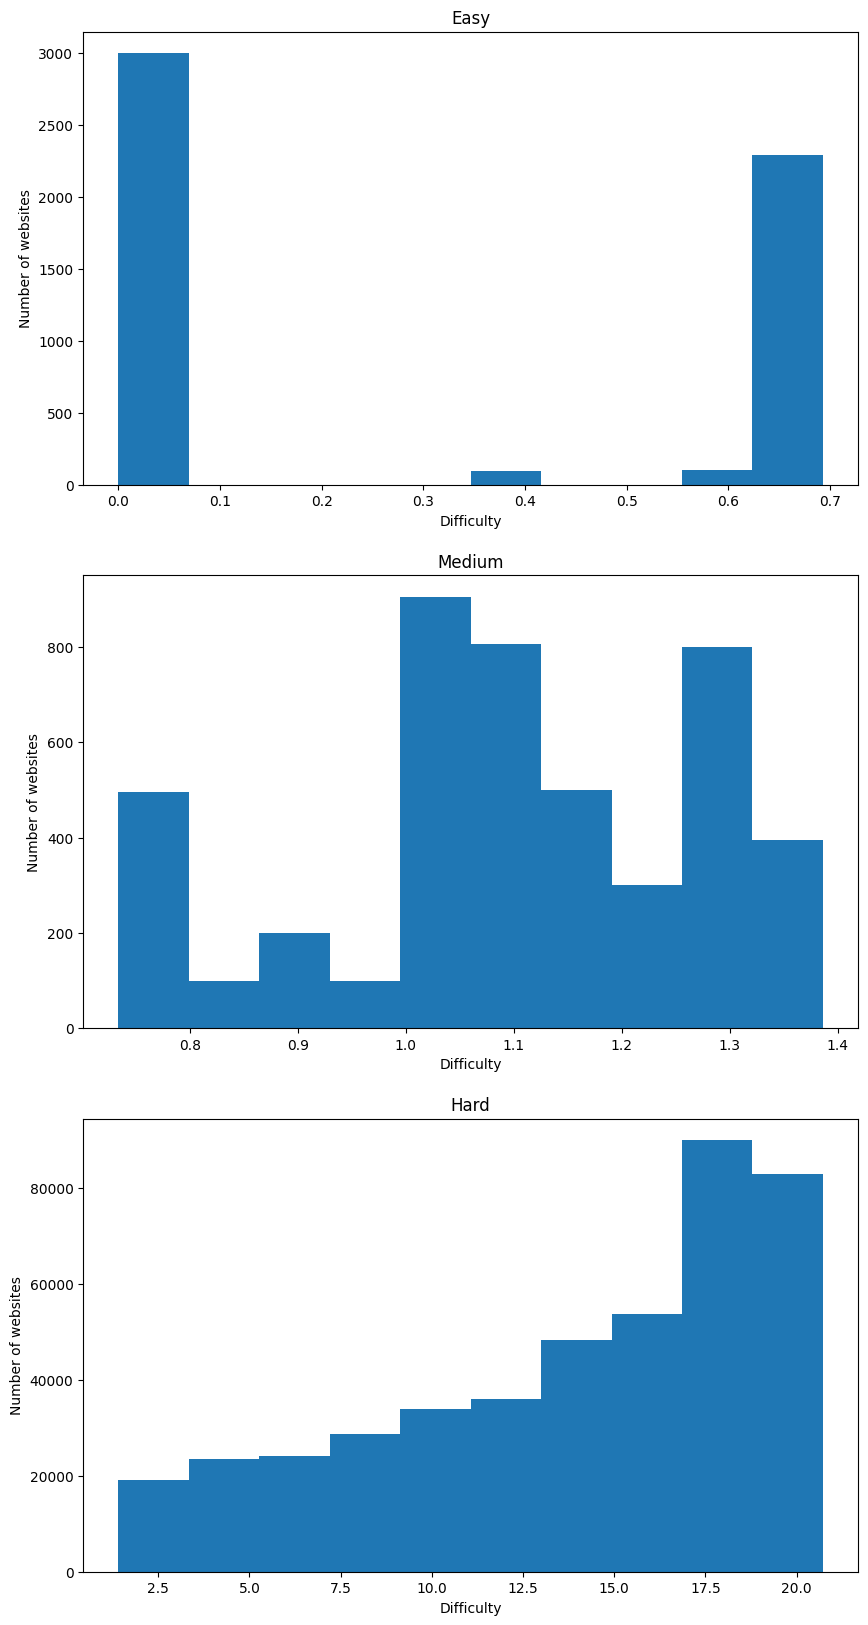

In [51]:
# Plot distributions for each on separate subplots to see if they look reasonable
fig, axs = plt.subplots(3, 1, figsize=(10, 20))
axs[0].hist([website.difficulty for website in easy_websites])
axs[1].hist([website.difficulty for website in medium_websites])
axs[2].hist([website.difficulty for website in hard_websites])
# Please label and color them properly

axs[0].set_title('Easy')
axs[1].set_title('Medium')
axs[2].set_title('Hard')

axs[0].set_xlabel('Difficulty')
axs[1].set_xlabel('Difficulty')
axs[2].set_xlabel('Difficulty')

axs[0].set_ylabel('Number of websites')
axs[1].set_ylabel('Number of websites')
axs[2].set_ylabel('Number of websites')



In [53]:
easy_designs = [website.convert_to_design() for website in easy_websites]
medium_designs = [website.convert_to_design() for website in medium_websites]
hard_designs = [website.convert_to_design() for website in hard_websites]

In [ ]:
# Save all of the designs from subsets_to_use in a single json file
difficulty_mapping = {
    1: easy_designs,
    2: medium_designs,
    3: hard_designs
}

base_dir = os.path.join('../../../',
                        'a2perf/domains/web_navigation/environment_generation',
                        'data', 'difficulty_levels')
os.makedirs(base_dir, exist_ok=True)

for difficulty_level, designs in difficulty_mapping.items():
  difficulty_level_path = os.path.join(base_dir, f'{difficulty_level:02d}.json')
  json.dump(designs, open(difficulty_level_path, 'w'))


In [4]:
import gymnasium as gym
from a2perf.domains import web_navigation

env = gym.make('WebNavigation-v0', difficulty=1, num_websites=10,
               render_mode='image')
obs, info = env.reset()

#

# Write a simple loop to capture some screenshots of websites
NUM_SCREENSHOTS = 100
screenshots = []
env.reset()
for i in range(NUM_SCREENSHOTS):
  screenshots.append(env.render())
  action = env.action_space.sample()
  obs, rew, terminated, truncated, info = env.step(action)
  print(env.current_website.difficulty)
  if terminated or truncated:
    env.reset()

env.close()
del env

screenshots

base_url:  file:///home/ike2030/workspace/a2perf/rl-perf/a2perf/domains/web_navigation/gwob/
base_url:  file:///home/ike2030/workspace/a2perf/rl-perf/a2perf/domains/web_navigation/gwob/
url:  file:///home/ike2030/workspace/a2perf/rl-perf/a2perf/domains/web_navigation/gwob/gminiwob/generic_website.html
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
7.441457660127796
5.093656990058512
5.093656990058512
5.093656990058512
5.093656990058512
5.093656990058512
5.093656990058512
5.093656990058512
5.093656990058512
5.093656990058512
5.093656990058512
5.093656990058512
5.093656990058512
5.093656990058512
5.09365699005

[<PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=375x667>,
 <PIL.Image.Image image mode=RGB size=37

### Approach 3: Linear increments of difficulty


I'm thinking about how we can take this set of websites and turn them into difficulty levels for the agent. For other tasks like quadruped locomotion, we have specific motions like 'dog_pace' or 'dog_spin' that vary naturally in difficulty level. Here we have a collection of websites that vary in difficulty score.

This difficulty score is a function of the number of primitives that appear on the page. We take the negative log probability of the web navigation agent **interacting** with the correct primitives on the page. This is a proxy for the difficulty of the website, but it's not a perfect measure. With our current measure, I think that active primitives are not assigned enough difficulty. For example, a textbox for address needs the agent to match the correct element from the user profile dictionary to the textbox. It is not as difficult as free-form text entry, but it is still harder than merely clicking on a button.  

I think an easy way to define difficulty levels is to consider how MUCH of the set of websites the agent will see inclusively. For example, difficulty level 1 could just show the first 5% of websites in the set. Difficulty level 2 could show the first 10% of websites in the set. Difficulty level 3 could show the first 15% of websites in the set. And so on. 

In [10]:
# Let's write a function to look at properties of various subsets of websites

# Starting if we take the first 5% of websites
first_5_percent = websites[:int(len(websites) * 0.05)]


(array([7810.,  610., 2000., 5220., 3920., 3400., 7280., 5895., 5075.,
        8790.]),
 array([-2.99998500e-05,  6.05847472e-02,  1.21199494e-01,  1.81814241e-01,
         2.42428988e-01,  3.03043735e-01,  3.63658482e-01,  4.24273229e-01,
         4.84887976e-01,  5.45502723e-01,  6.06117470e-01]),
 <BarContainer object of 10 artists>)

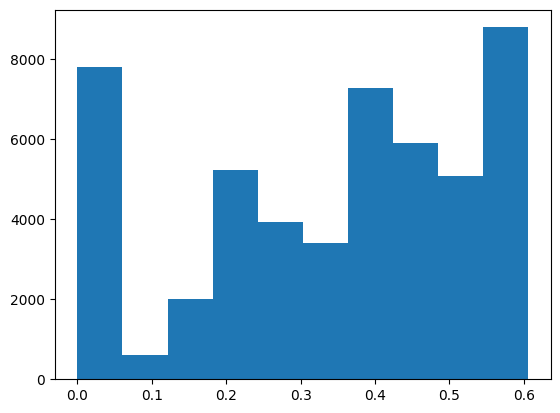

In [11]:
# Plot histogram of website difficulties
plt.hist([website.difficulty for website in first_5_percent])

In [12]:
# How many primitives on average?
num_primitives = [website._total_num_primitives for website in first_5_percent]
difficulties = [website.difficulty for website in first_5_percent]
# Show stats for the num primitives
import numpy as np

print(np.mean(num_primitives), np.std(num_primitives), np.min(num_primitives),
      np.max(
          num_primitives))
print(np.mean(difficulties), np.std(difficulties), np.min(difficulties), np.max(
    difficulties))

12.7393 7.711143592879075 1 31
0.33890740822407067 0.1940030045131845 -2.9999850001196526e-05 0.6061174704050358


In [13]:
first_10_percent = websites[:int(len(websites) * 0.1)]

num_primitives = [website._total_num_primitives for website in first_10_percent]
difficulties = [website.difficulty for website in first_10_percent]

print(np.mean(num_primitives), np.std(num_primitives), np.min(num_primitives),
      np.max(
          num_primitives))
print(np.mean(difficulties), np.std(difficulties), np.min(difficulties), np.max(
    difficulties))

15.19075 8.023450905782374 1 34
0.5597751348148549 0.26806573285324226 -2.9999850001196526e-05 0.9342837831553402


In [14]:
# Let's show a plot that depicts how the difficulty changes when moving in increments of 5% of the websites
def get_difficulty_stats(websites):
  num_primitives = [website._total_num_primitives for website in websites]
  difficulties = [website.difficulty for website in websites]

  return np.mean(num_primitives), np.std(num_primitives), np.min(
      num_primitives), np.max(
      num_primitives), np.mean(difficulties), np.std(difficulties), np.min(
      difficulties), np.max(
      difficulties)


increments = list(range(5, 100, 1))
difficulty_stats = []
for increment in increments:
  websites_subset = websites[:int(len(websites) * (increment / 100))]
  difficulty_stats.append(get_difficulty_stats(websites_subset))



Text(0, 0.5, 'Mean difficulty')

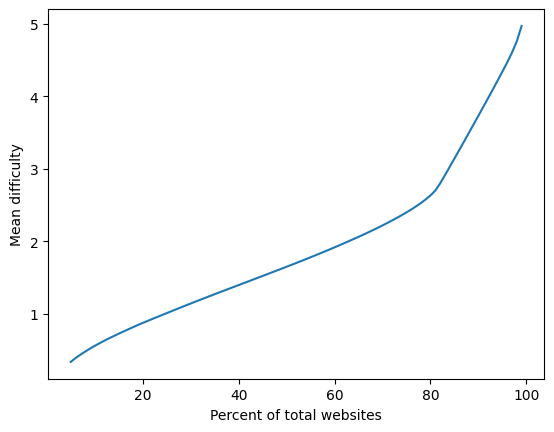

In [15]:
# Plot and label the mean difficulty
plt.plot(increments, [stat[4] for stat in difficulty_stats])
plt.xlabel('Percent of total websites')
plt.ylabel('Mean difficulty')

## Verdict
Based on the results shown, I think it is reasonable to use the mean difficulty as a proxy for the difficulty of the set of websites. We can use this to define difficulty levels for the agent. The difficulty seems to rise linearly with the proportion of websites shown. So difficulty levels 1 through 80 are linear, but we see a sharp increase in difficulty. So let's have 80 difficulty levels, with difficulty_level=80 including all websites.

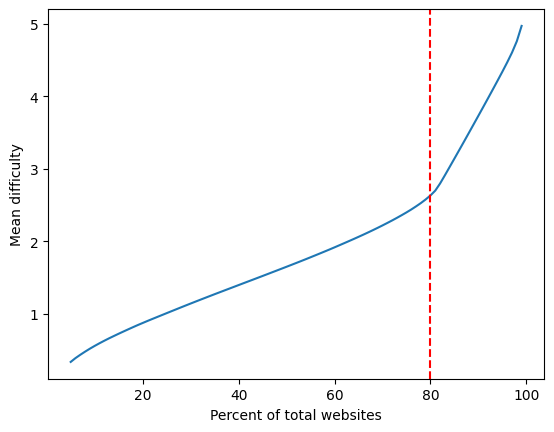

In [16]:
# Draw the graph but with a vertical dashed line at 80 percent

# Plot and label the mean difficulty
plt.plot(increments, [stat[4] for stat in difficulty_stats])
plt.xlabel('Percent of total websites')
plt.ylabel('Mean difficulty')
plt.axvline(x=80, color='r', linestyle='--')


In [18]:
import json

In [19]:
# We should cache a list of designs that are used for each difficulty level in increments of 1, then ship that with the codebase
os.makedirs(os.path.join('../../../',
                         'a2perf/domains/web_navigation/environment_generation',
                         'data', 'difficulty_levels'), exist_ok=True)
for i in range(1, 80):
  designs_subset = designs[:int(len(designs) * (i / 100))]
  designs_subset_path = os.path.join('../../../',
                                     'a2perf/domains/web_navigation/environment_generation',
                                     'data', 'difficulty_levels',
                                     f'{i:02d}.json')
  # Save as json since it's a list of dicts
  json.dump(designs_subset, open(designs_subset_path, 'w'))

In [21]:
# final difficulty level is all websites
json.dump(designs, open(os.path.join('../../../',
                                     'a2perf/domains/web_navigation/environment_generation',
                                     'data', 'difficulty_levels',
                                     f'80.json'), 'w'))

In [ ]:
# What's the command to zip up the data folder?
# zip -r data.zip data